## Multilabel Classification

In [1]:
from sklearn import datasets
from kiwigrad import MLP, Value, Layer, draw_dot
import pandas as pd
import numpy as np
import edamame.eda as eda
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

### Dataset

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(X.shape)
print(type(X))
print(y.shape)
print(type(y))
num_classes = len(np.unique(y))

(150, 4)
<class 'numpy.ndarray'>
(150,)
<class 'numpy.ndarray'>


In [3]:
X = pd.DataFrame(X, columns=iris.feature_names)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
y = pd.Series(y)
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [5]:
X_train, y_train, X_test, y_test = eda.setup(X,y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112, 4)
(38, 4)
(112,)
(38,)


In [6]:
X_train_s = eda.scaling(X_train)
X_test_s = eda.scaling(X_test)
y_train = y_train.squeeze().to_numpy()
y_test = y_test.squeeze().to_numpy()

In [7]:
y_train_ohe = np.eye(num_classes)[y_train]
y_train_ohe[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [8]:
inputs = [[Value(i) for i in elem] for elem in X_train_s.to_numpy()]
print(inputs[0])

[Value(data=-1.018271, grad=0.000000), Value(data=1.286460, grad=0.000000), Value(data=-1.393389, grad=0.000000), Value(data=-1.362177, grad=0.000000)]


### Multi layer perceptron

In [9]:
class PotNet(MLP):
    def __init__(self):
        layers = [
            Layer(nin=4, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=3, bias=True, activation="linear")
        ]
        super().__init__(layers=layers)

model = PotNet()
y_pred = model(inputs[0])
print(y_pred)

[Value(data=2.963813, grad=0.000000), Value(data=-3.522833, grad=0.000000), Value(data=-2.625890, grad=0.000000)]


### Full batch gradient descent with cross entropy loss

In [10]:
def cross_entropy_loss(forward_array, y_true):
    exp_forward = [elem.exp() for _, elem in enumerate(forward_array)]
    norm_term = Value(0.)
    for _, elem in enumerate(exp_forward):
        norm_term = norm_term + elem
    softmax_vec = [elem / norm_term for _, elem in enumerate(exp_forward)]
    bce_losses = []
    for j in range(len(softmax_vec)):
        output = softmax_vec[j]
        target = Value(y_true[j])
        neg_output = Value(1.) - softmax_vec[j]
        bce_loss = -(target * output.log() + (Value(1)-target)*neg_output.log())
        bce_losses.append(bce_loss)
    BCEloss = Value(0.)
    for _, single_loss in enumerate(bce_losses):
        BCEloss = BCEloss + single_loss
    BCEloss.backward()
    y_predicted = [elem.data for _, elem in enumerate(softmax_vec)]
    return BCEloss, y_predicted.index(max(y_predicted))


In [11]:
def accuracy_val(y_pred, y_true):
    y_pred = np.array(y_pred).round()
    correct_results = np.sum(y_pred == y_true)
    acc = correct_results/y_true.shape[0]
    acc = np.round(acc * 100)
    return acc

In [12]:
epochs = 200
lr = 0.001
for epoch in range(epochs):
    y_pred = []
    losses = []
    s = time.monotonic()
    for i in range(len(inputs)):
        forward = model(inputs[i])
        loss, y_pred_i = cross_entropy_loss(forward_array=forward, y_true=y_train_ohe[i])
        losses.append(loss.data)
        y_pred.append(y_pred_i)
        for p in model.parameters():
            p.data += -lr * p.grad
        model.zero_grad()
    e = time.monotonic()
    t = e - s
    acc = accuracy_val(y_pred=y_pred, y_true=y_train)
    loss_epoch = sum(losses) / len(losses)
    if epoch % 10 == 0 or epoch==(epochs-1):
        print(f"epoch: {epoch} | loss: {loss_epoch:.2f} | time: {t:.2f} sec. | acc: {acc:.2f}%")

epoch: 0 | loss: 2.63 | time: 0.06 sec. | acc: 42.00%
epoch: 10 | loss: 0.51 | time: 0.04 sec. | acc: 94.00%
epoch: 20 | loss: 0.34 | time: 0.04 sec. | acc: 95.00%
epoch: 30 | loss: 0.26 | time: 0.04 sec. | acc: 96.00%
epoch: 40 | loss: 0.22 | time: 0.05 sec. | acc: 96.00%
epoch: 50 | loss: 0.19 | time: 0.05 sec. | acc: 97.00%
epoch: 60 | loss: 0.16 | time: 0.05 sec. | acc: 98.00%
epoch: 70 | loss: 0.14 | time: 0.05 sec. | acc: 98.00%
epoch: 80 | loss: 0.12 | time: 0.05 sec. | acc: 99.00%
epoch: 90 | loss: 0.11 | time: 0.05 sec. | acc: 99.00%
epoch: 100 | loss: 0.11 | time: 0.05 sec. | acc: 99.00%
epoch: 110 | loss: 0.10 | time: 0.05 sec. | acc: 99.00%
epoch: 120 | loss: 0.09 | time: 0.05 sec. | acc: 99.00%
epoch: 130 | loss: 0.09 | time: 0.05 sec. | acc: 99.00%
epoch: 140 | loss: 0.08 | time: 0.05 sec. | acc: 99.00%
epoch: 150 | loss: 0.08 | time: 0.04 sec. | acc: 99.00%
epoch: 160 | loss: 0.07 | time: 0.05 sec. | acc: 99.00%
epoch: 170 | loss: 0.07 | time: 0.05 sec. | acc: 99.00%
epo

## Result 

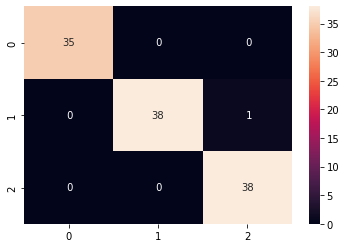

In [13]:
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="2.0f")
plt.show()

In [15]:
index = 7
print(y_train_ohe[index])
forward = model(inputs[index])
exp_forward = [elem.exp() for _, elem in enumerate(forward)]
norm_term = Value(0.)
for _, elem in enumerate(exp_forward):
    norm_term = norm_term + elem
softmax_vec = [elem / norm_term for _, elem in enumerate(exp_forward)]
print(softmax_vec)

[0. 1. 0.]
[Value(data=0.004021, grad=0.000000), Value(data=0.995445, grad=0.000000), Value(data=0.000533, grad=0.000000)]


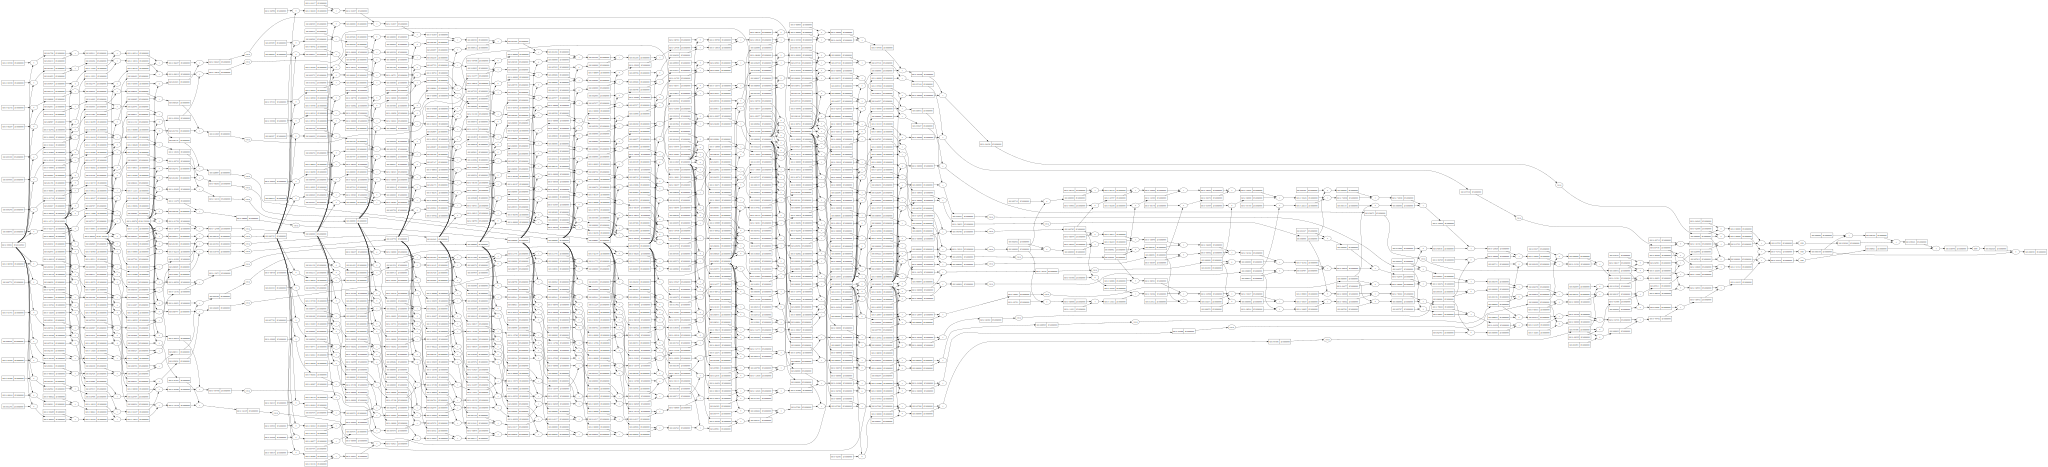

In [16]:
draw_dot(softmax_vec[0])